# **Data & Preprocessing**

In [1]:
import pandas as pd
energy_data = pd.read_csv(r'C:\Users\Βαγγέλης\Desktop\Σχολή\4o Έτος\7ο Εξάμηνο\Μηχανική Μάθηση για Επιστήμη Δεδομένων και Ανάλυση\Ασκήσεις\Projects\Final Project\energydata_complete.csv')
print(energy_data.head())

                  date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Windspeed  Visibility

As you can see our chosen dataset consists of 29 columns. Lets see what each column represents:


1.   **Date**: Timestamp of each measurement
2.   **Appliances**: Energy use of appliances (in Wh)
3.  **lights**: Energy use of lights (in  Wh)
4.  **T1 ... T9**: Temperature readings in different areas
5.  **RH_1 ... RH_9**: Relative humidity in different areas
6.  **T_out**: Outdoor temperature
7.  **Press_mm_hg**: Pressure in mmHg
8.  **RH_out**: Outdoor relative humidity
9.  **Windspeed**: Outdoor windspeed
10. **Visibility**: Outdoor visibility
11. **Tdewpoint**: Dew point temperature
12. **rv1 and rv2**: Random variables for anonymization



## Dataset Description:
>The data represents energy consumption and environmental variables collected from a low-energy house in Stambruges, Belgium. This house adheres to passive house standards, incorporating energy-efficient features like triple-glazed windows, high-efficiency ventilation, and low air leakage.
**Key details**:


1.  **Source**: Data was collected using M-BUS energy counters for appliances and lights, a ZigBee wireless sensor network for temperature and humidity, and weather data from a nearby airport station (Chièvres Airport).
2. **Variables**:
  * **Energy**: Consumption by appliances (primary focus) and lights.
  * **Indoor Environment**: Temperature and humidity from multiple rooms (e.g., kitchen, living room, laundry).
  * **Outdoor Environment**: Temperature, humidity, wind speed, pressure, visibility, and dew point from the weather station.

3. **Time Granularity**: 10-minute intervals.
4. **Duration**: Approximately 4.5 months, covering 137 days.



## Data cleaning:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot
import numpy as np
from sklearn.preprocessing import StandardScaler

energy_data['date'] = pd.to_datetime(energy_data['date'])
energy_data.set_index('date', inplace=True)

if energy_data.isnull().sum().sum() > 0:
    energy_data.fillna(method='ffill', inplace=True)

z_scores = np.abs((energy_data - energy_data.mean()) / energy_data.std())
energy_data = energy_data[(z_scores < 3).all(axis=1)]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(energy_data)
scaled_data = pd.DataFrame(scaled_data, columns=energy_data.columns, index=energy_data.index)

Trend Visualization:


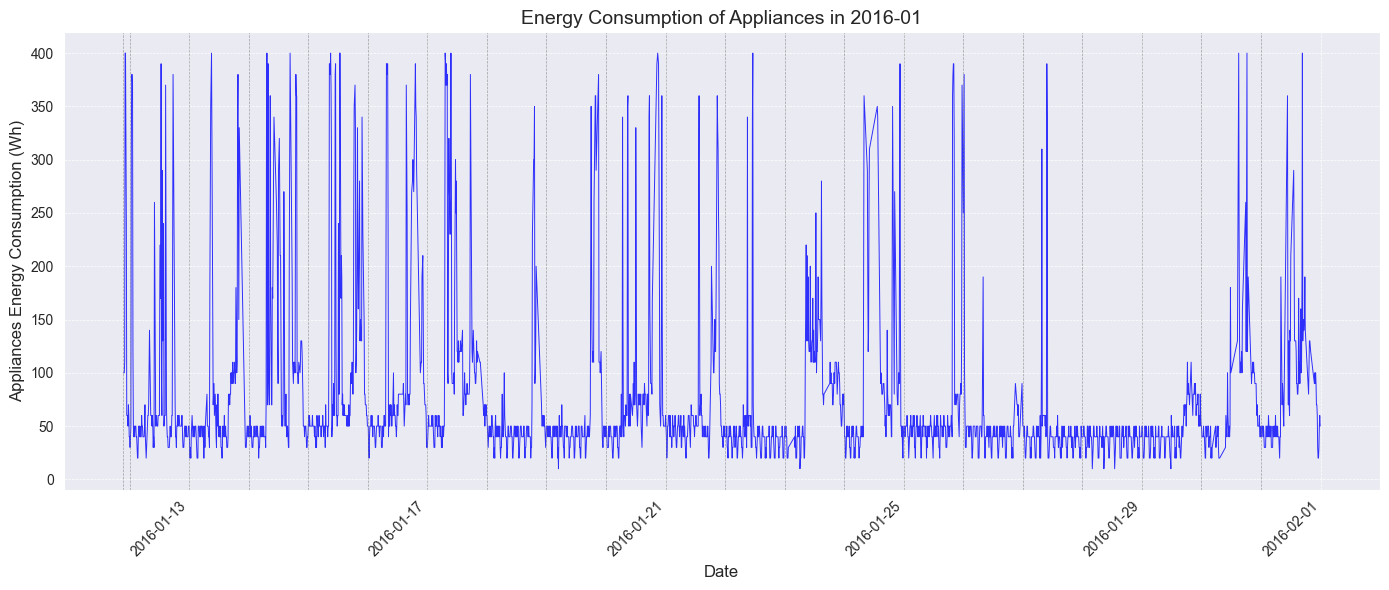

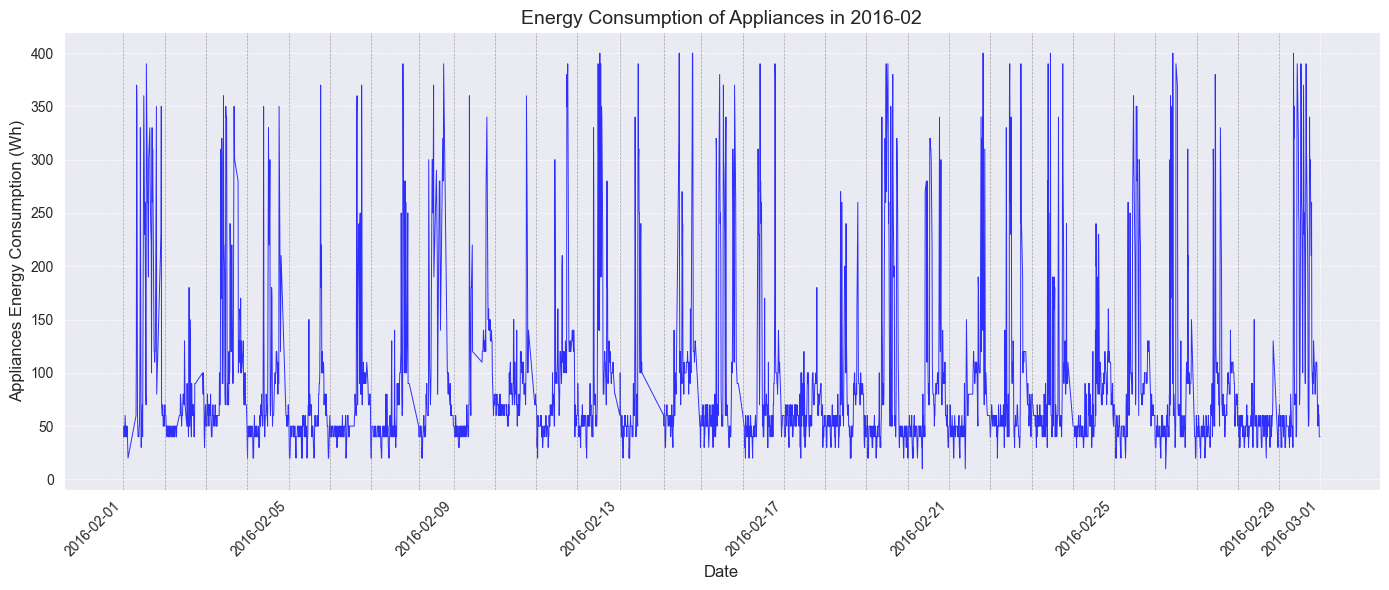

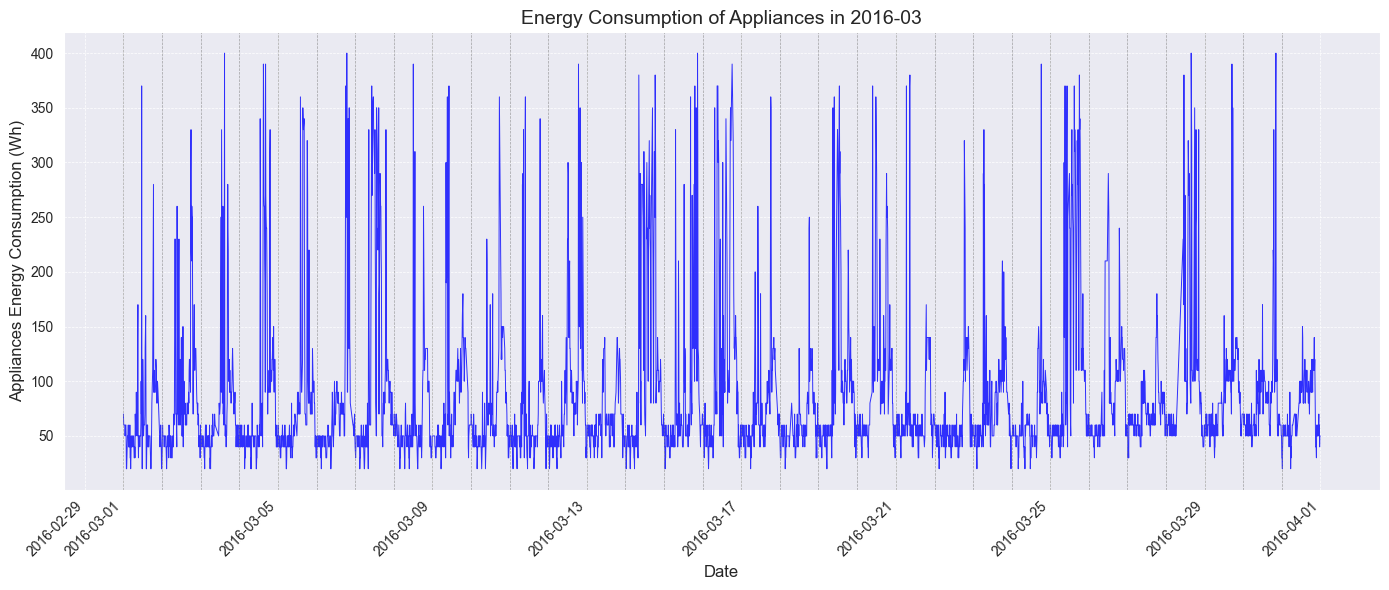

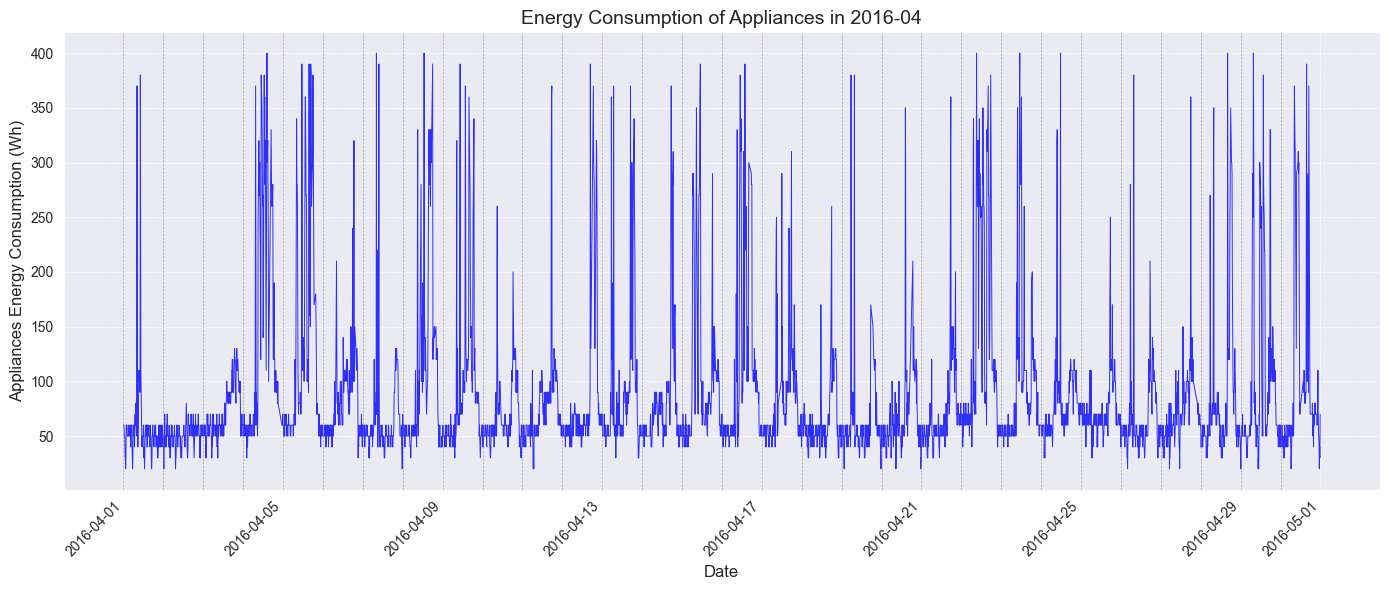

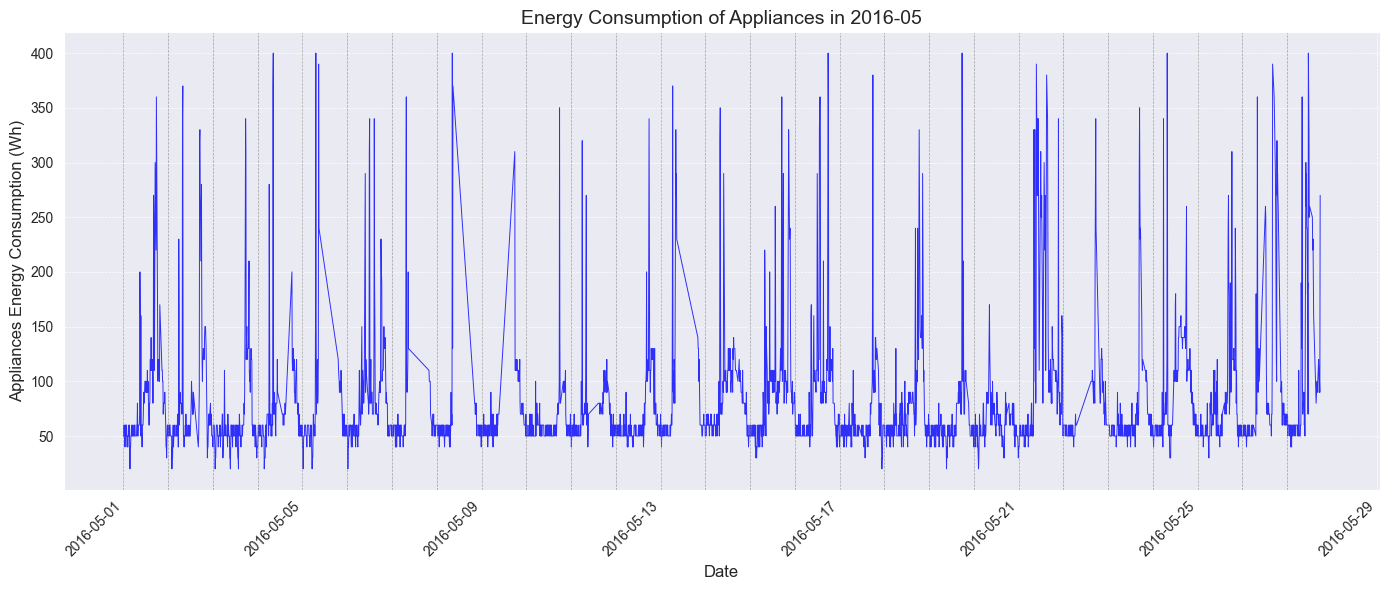

Weekday vs Weekend average:


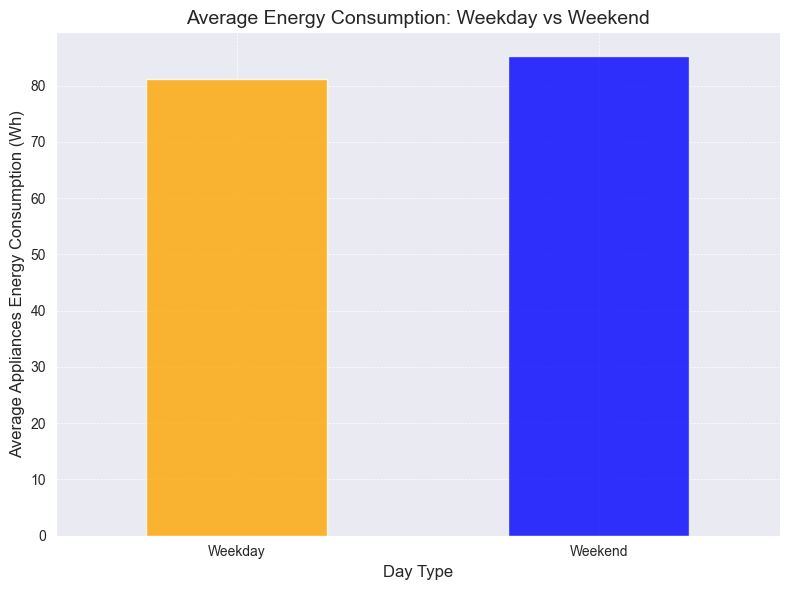

Seasonal:


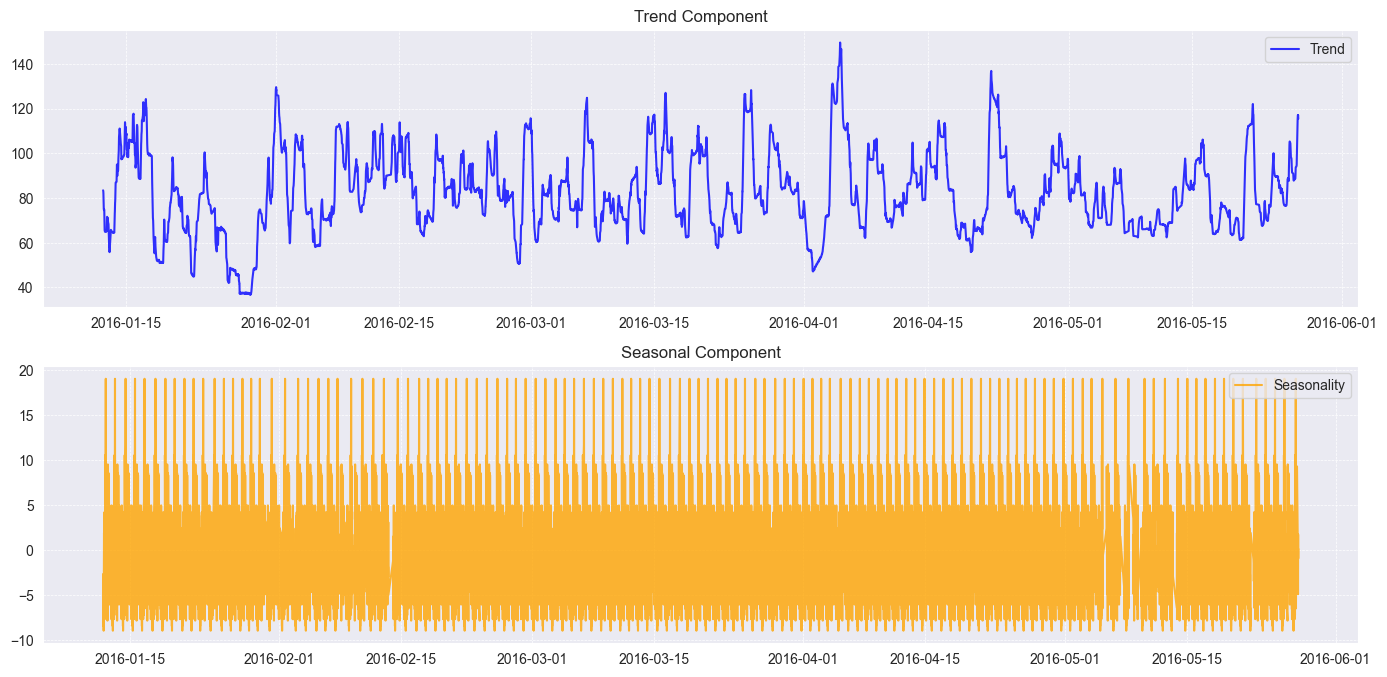

Autocorrelation plot:


<Figure size 1200x600 with 0 Axes>

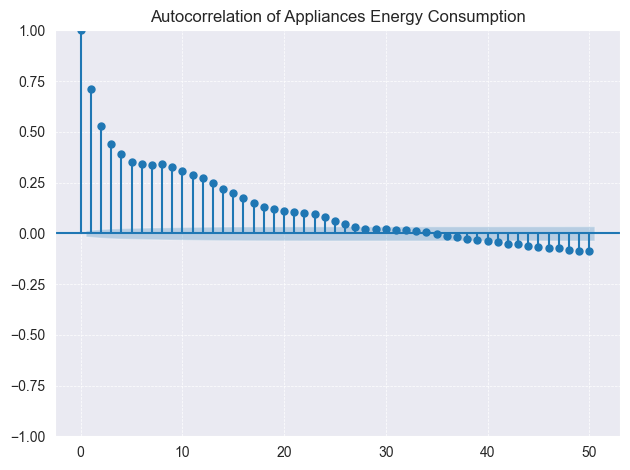

Stationarity check:
ADF Test Results:
ADF Statistic: -21.609593410592964
p-value: 0.0
Critical Values: {'1%': np.float64(-3.4307274611324305), '5%': np.float64(-2.861706823136832), '10%': np.float64(-2.5668587956436157)}


In [3]:
print("Trend Visualization:")
months = energy_data.index.to_period("M").unique()

for month in months:
    plt.figure(figsize=(14, 6))
    month_data = energy_data[month.start_time:month.end_time]['Appliances']
    month_data.plot(color='blue', linewidth=0.7, alpha=0.8)
    for day in month_data.index.day.unique():
        plt.axvline(x=month_data.index[month_data.index.day == day][0], color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title(f'Energy Consumption of Appliances in {month}', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Appliances Energy Consumption (Wh)', fontsize=12)
    plt.grid(visible=True, linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

energy_data['day_of_week'] = energy_data.index.dayofweek
energy_data['day_type'] = energy_data['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

avg_consumption = energy_data.groupby('day_type')['Appliances'].mean()

print("Weekday vs Weekend average:")
plt.figure(figsize=(8, 6))
avg_consumption.plot(kind='bar', color=['orange', 'blue'], alpha=0.8)
plt.title('Average Energy Consumption: Weekday vs Weekend', fontsize=14)
plt.ylabel('Average Appliances Energy Consumption (Wh)', fontsize=12)
plt.xlabel('Day Type', fontsize=12)
plt.xticks(rotation=0)
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


print("Seasonal:")
seasonal_decompose_result = seasonal_decompose(energy_data['Appliances'], model='additive', period=144)
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.plot(seasonal_decompose_result.trend, label='Trend', color='blue', alpha=0.8)
plt.title('Trend Component')
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(seasonal_decompose_result.seasonal, label='Seasonality', color='orange', alpha=0.8)
plt.title('Seasonal Component')
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.legend()

plt.tight_layout()
plt.show()

print("Autocorrelation plot:")
plt.figure(figsize=(12, 6))
plot_acf(energy_data['Appliances'], lags=50, title="Autocorrelation of Appliances Energy Consumption")
plt.grid(visible=True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

print("Stationarity check:")
adf_test = adfuller(energy_data['Appliances'])
print("ADF Test Results:")
print(f"ADF Statistic: {adf_test[0]}")
print(f"p-value: {adf_test[1]}")
print("Critical Values:", adf_test[4])

>Across all months, the appliance energy consumption shows a repeating daily cycle with noticeable spikes and dips. These patterns are likely linked to human activities such as morning, evening, and night routines. We could confidently assume that the spikes in energy usage we can observe are due to daytime activities since they are also prominent in the middle of the days observed.

Month-to-Month Variations:

* January 2016: Shows consistent daily patterns with moderate peaks.
* February 2016: More prominent spikes, possibly due to colder weather leading to higher appliance usage for heating.
* March to May 2016: Peaks remain consistent, but daily usage appears slightly higher in March and April compared to January. This may reflect seasonal or behavioral changes.


**The dataset exhibits strong short-term dependencies, making it well-suited for time-series models like ARIMA or LSTM that rely on lagged values.**

In [4]:
for lag in range(1, 4):
    energy_data[f'Appliances_lag_{lag}'] = energy_data['Appliances'].shift(lag)

energy_data['Appliances_rolling_mean'] = energy_data['Appliances'].rolling(window=3).mean()
energy_data['Appliances_rolling_std'] = energy_data['Appliances'].rolling(window=3).std()

energy_data['hour'] = energy_data.index.hour
energy_data['day'] = energy_data.index.day
energy_data['weekday'] = energy_data.index.weekday
energy_data['month'] = energy_data.index.month

energy_data['hour_sin'] = np.sin(2 * np.pi * energy_data['hour'] / 24)
energy_data['hour_cos'] = np.cos(2 * np.pi * energy_data['hour'] / 24)
energy_data['weekday_sin'] = np.sin(2 * np.pi * energy_data['weekday'] / 7)
energy_data['weekday_cos'] = np.cos(2 * np.pi * energy_data['weekday'] / 7)

energy_data['lag1_lag2_interaction'] = energy_data['Appliances_lag_1'] * energy_data['Appliances_lag_2']

daily_stats = energy_data.resample('D').agg({
    'Appliances': ['mean', 'sum', 'min', 'max']
})
daily_stats.columns = ['daily_mean', 'daily_sum', 'daily_min', 'daily_max']
energy_data = energy_data.merge(daily_stats, left_index=True, right_index=True, how='left')

energy_data.dropna(inplace=True)

cleaned_data_path = 'cleaned_energy_data.csv'
energy_data.to_csv(cleaned_data_path)

print(f"Cleaned data saved to {cleaned_data_path}")

Cleaned data saved to cleaned_energy_data.csv
